## DataSet Exploration PASTIS

Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import os 
import random
import matplotlib.pyplot as plt
from typing import List
import matplotlib.ticker as ticker
from documentation.label_info import label_names, label_colors

Create a list of all the files that are in the PATIS folder.

There's three subdirectories:
- Annotations
- Sentinel Data
- Instance Annotations



In [2]:
path = './data/PASTIS/'

# Find all files in the subdirectories
annotations_path = os.path.join(path, 'ANNOTATIONS')
data_s2_path = os.path.join(path, 'DATA_S2')
instance_path = os.path.join(path, 'INSTANCE_ANNOTATIONS')

# Create relative paths for each file
annotations = [os.path.join(annotations_path, f) for f in os.listdir(annotations_path) if f.endswith('npy')]
data_s2 = [os.path.join(data_s2_path, f) for f in os.listdir(data_s2_path) if f.endswith('npy')]
instance_annotations = [os.path.join(instance_path, f) for f in os.listdir(instance_path) if f.endswith('npy')]

# Create a dictionary with the file identifiers as keys and the paths as values
annotations = {p.split('_')[-1][:-4]: p for p in annotations}
data_s2 = {p.split('_')[-1][:-4]: p for p in data_s2}
instance_annotations = {p.split('_')[-1][:-4]: p for p in instance_annotations}

In [3]:
an_len, dat_len, in_len = len(annotations), len(data_s2), len(instance_annotations)
print(f"Number of annotations:\t\t{an_len}\nNumber of sentinel data:\t{dat_len}\nNumber of instc. annotations:\t{in_len}")

Number of annotations:		2433
Number of sentinel data:	2468
Number of instc. annotations:	2433


Now we combine all the file paths in a dictionary, based on their ID. 

In [5]:
all_files = {}

data_paths = {
    'annotation': annotations, 
    'sentinel': data_s2, 
    'instance': instance_annotations
}

for name, data in data_paths.items():
    for k, v in data.items():
        if k in all_files:
            all_files[k][name] = v
        else:
            all_files[k] = {name: v}

print(f"The combined files results in a dictionary of length: {len(all_files)}")

The combined files results in a dictionary of length: 2468


In [6]:
_missing = len([(k, v) for k, v in all_files.items() if len(v) < 3])
all_files = dict([(k, v) for k,v in all_files.items() if len(v) == 3])
print(f"There are {_missing} patches with less than 3 files\nThis results in {len(all_files)} patches")

There are 35 patches with less than 3 files
This results in 2433 patches


# WTF IS HAPPENING HERE?

In [13]:
all_annos = [np.load(f) for f in [c['annotation'] for c in list(all_files.values())]]
weird_annos = [a[0] for a in all_annos if a[0].max() > 19]
len(weird_annos)

1170

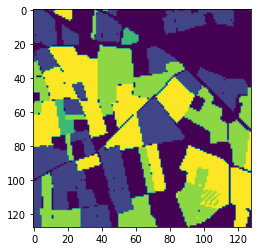

In [40]:
stat_list = [(ala.shape, ({'0': (ala[0].min(), ala[0].max()), '1': (ala[1].min(), ala[1].max()), '2': (ala[2].min(), ala[2].max())}) if ala.shape[0] == 3 else\
    ({'0': (ala.min(), ala.max())}))\
        for ala in all_annos]

plt.imshow(all_annos[1])

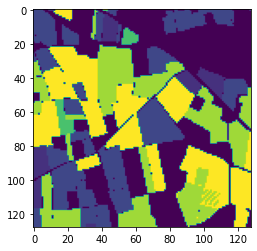

In [48]:
plt.imshow(np.floor(all_annos[1] / 10**6))

## Now let's explore some of the data in more detail

In [11]:
def load_patch(patch_paths: list):
    """
    Loads a patch from a list of paths
    """
    patch = []
    for path in patch_paths:
        patch.append(np.load(path))
    return patch

In [ ]:
def generate_random_patch(patch_list: list):
    """
    Generates a random patch from a list of patches
    """
    _tp = random.choice(list(patch_list.items()))
    _tp_dict = {
        'id': _tp[0],
        'annotation': np.load(_tp[1]['annotation']),
        'sentinel': np.load(_tp[1]['sentinel']),
        'instance': np.load(_tp[1]['instance'])
        
    }
    if _tp_dict['annotation'].shape[0] == 3:
        _tp_dict['annotation'] = np.transpose(_tp_dict['annotation'], (1, 2, 0))

    return _tp_dict

We select a random patch to visualize

In [ ]:
test_patch = generate_random_patch(all_files)
test_patch['id'], test_patch['annotation'].shape, test_patch['sentinel'].shape, test_patch['instance'].shape

In [ ]:
def plot_three_types(patch: dict, time: int = 0, spectral: int = 0, figsize: tuple = (15, 5), grey: bool = False):
    fig, ax = plt.subplots(ncols=3, figsize=figsize)
    ax[0].imshow(patch['annotation'], cmap='gray' if grey else None)
    ax[0].set_title('Annotation')
    ax[1].imshow(patch['sentinel'][time, spectral, :, :], cmap='gray' if grey else None)
    ax[1].set_title('Sentinel')
    ax[2].imshow(patch['instance'], cmap='gray' if grey else None)
    ax[2].set_title('Instance')

In [ ]:
for i in range(4):
    random_time = random.randint(0, test_patch['sentinel'].shape[1])
    plot_three_types(test_patch, time=random_time, figsize=(8, 4))

In [ ]:
len(np.unique(test_patch['annotation']))

In [ ]:
def patch_labels(patch: dict, figsize: tuple = (15, 15)):
    """
    Plots the labels of a patch
    """
    annotation = patch['annotation']
    annotated_pixels = {}
    for i, label in label_names.items():
        class_image = annotation.copy()
        class_image[class_image != int(i)] = 0
        class_image[class_image == int(i)] = 1
        annotated_pixels[label] = class_image

    class_num = 19
    cols = int(np.ceil(np.sqrt(class_num)))
    rows = class_num // cols + 1

    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)

    for i, label in enumerate(annotated_pixels):
        c, r = i % cols, i // cols
        if i > class_num:
            axs[r, c].set_visible(False)
            continue
    
        axs[r, c].imshow(annotated_pixels[label])
        axs[r, c].set_title(label)
    
    return

patch_labels(test_patch)

In [ ]:
def random_test_patch(all_files: list):
    _tp = random.choice(list(all_files.items()))
    _tp_load = load_patch(_tp[1])
    return (_tp_load, _tp[0])

test_patch = random_test_patch(all_files)
test_patch[0][0].shape, test_patch[0][1].shape, test_patch[0][2].shape, test_patch[1]

In [ ]:
def plot_patch(full_patch: tuple):
    """
    Plots a patch
    """
    patch = full_patch[0].copy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Patch {full_patch[1]}")

    axs[0].set_title('Annotations')
    _corrected = np.moveaxis(patch[0], 0, -1)
    axs[0].imshow(_corrected)

    rand_time = random.randint(0, patch[1].shape[0]-1)
    rand_spec = random.randint(0, patch[1].shape[1]-1)
    axs[1].set_title('Sentinel-2')
    axs[1].imshow(patch[1][rand_time, rand_spec, :, :], cmap='gray')

    axs[2].set_title('Instance annotations')
    axs[2].imshow(patch[2])

In [ ]:
def plot_patch_with_labels(patch: np.ndarray, figsize:tuple):

    if patch.shape[0] == 3:
        patch = np.moveaxis(patch, 0, -1)

    num_unique = 19

    cols = int(np.ceil(np.sqrt(num_unique)))
    rows = num_unique // cols + 1

    fig, axs = plt.subplots(rows, cols, figsize=figsize)

    for i in range(cols*rows):
        c, r = i // cols, i % cols
        if i >= num_unique:
            axs[c, r].set_visible(False)
            continue
        
        _t = patch.copy()
        _t[_t != i] = 0
        _t[_t == i] = 1
        axs[c, r].xaxis.set_major_locator(ticker.NullLocator())
        axs[c, r].yaxis.set_major_locator(ticker.NullLocator())
        axs[c, r].set_title(label_names[i])
        axs[c, r].imshow(_t)
        

In [ ]:
patch = another[0][0]

if patch.shape[0] == 3:
        patch = np.moveaxis(patch, 0, -1)

num_unique = 19

cols = int(np.ceil(np.sqrt(num_unique)))
rows = num_unique // cols + 1

# fig, axs = plt.subplots(rows, cols, figsize=(15, 13))

print(patch.shape, np.unique(patch))
# for i in range(cols*rows):
#     c, r = i // cols, i % cols
#     if i >= num_unique:
#         axs[c, r].set_visible(False)
#         continue
    
#     _t = patch.copy()
#     _t[_t != i] = 0
#     _t[_t == i] = 1
#     axs[c, r].xaxis.set_major_locator(ticker.NullLocator())
#     axs[c, r].yaxis.set_major_locator(ticker.NullLocator())
#     axs[c, r].set_title(label_names[i])
#     axs[c, r].imshow(_t)

In [ ]:
# another = random_test_patch(all_files)
plot_patch(another)
plot_patch_with_labels(another[0][0], figsize=(15, 13))